<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/podcast_to_headline_del_spon_suger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [ ]:
!pip install word2vec

     |████████████████████████████████| 42 kB 346 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=17247558982177aa870e5bdafe40b4dd0cdc4a4a9d63ba4637622b8868ee67fb
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [ ]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [ ]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-04-14 23:43:13--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  1.96MB/s    in 15s     

2022-04-14 23:43:28 (1.98 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [ ]:
links = {'podcast_text': 'https://raw.githubusercontent.com/flora0110/podcast_segment_headine/main/podcast_data/SugarCravings.txt'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-04-14 23:43:31--  https://raw.githubusercontent.com/flora0110/podcast_segment_headine/main/podcast_data/SugarCravings.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15494 (15K) [text/plain]
Saving to: ‘SugarCravings.txt’

SugarCravings.txt   100%[===================>]  15.13K  --.-KB/s    in 0.001s  

2022-04-14 23:43:31 (29.2 MB/s) - ‘SugarCravings.txt’ saved [15494/15494]



## Train wordvectors

In [ ]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [ ]:
model.save(wrdvec_path)

In [ ]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [ ]:
!pip install textsplit

     |████████████████████████████████| 154 kB 5.3 MB/s 


In [ ]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [ ]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [ ]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

penalty 49.18
172 sentences, 8 segments, avg 21.50 sentences per segment
optimal score 5399.77, greedy score 5388.19
[5399.772041145196, 5388.194028311965]
(5399.772041145196, 5388.194028311965)
ratio of scores 1.0021


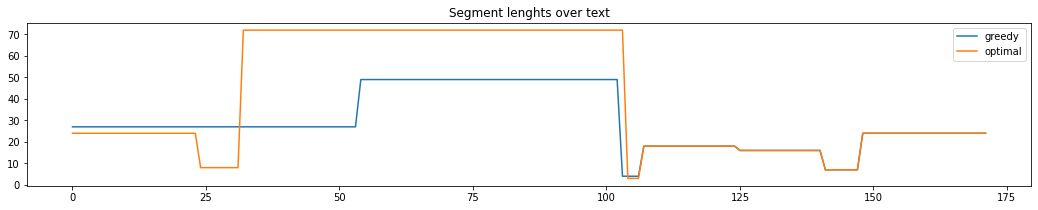

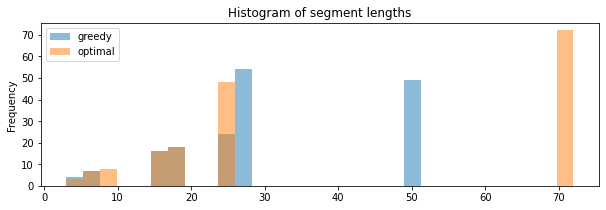

In [ ]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [ ]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Welcome to the huberman Lab podcast, where we discuss science and science based tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system regulates our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanisms. ", 'Isms, one of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding. ', "Even if you're not much of a sweet tooth. ", 'I confess. ', "I'm not most people enjoy sweet tastes more than bitter tastes and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally. ', 'Sweet taste al

In [ ]:
print(sentenced_text)

['Welcome to the huberman Lab podcast, where we discuss science and science based tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system regulates our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanisms. ", 'Isms, one of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding. ', "Even if you're not much of a sweet tooth. ", 'I confess. ', "I'm not most people enjoy sweet tastes more than bitter tastes and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally. ', 'Sweet taste al

### 處理輸入

In [ ]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [ ]:
print(podcast_test)

["Welcome to the huberman Lab podcast, where we discuss science and science based tools for everyday life. I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. Today. We are going to discuss sugar in particular how our nervous system regulates our sugar intake and are seeking of sugar. We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanisms. Isms, one of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding. Even if you're not much of a sweet tooth. I confess. I'm not most people enjoy sweet tastes more than bitter tastes and the Sweet Taste of sugar. And its various forms is strongly reinforcing. Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. Incidentally. Sweet taste also make us want to eat more of other substances.

# Headline generator

In [ ]:
! pip install transformers datasets

     |████████████████████████████████| 4.0 MB 5.6 MB/s 
     |████████████████████████████████| 325 kB 45.4 MB/s 
     |████████████████████████████████| 596 kB 35.1 MB/s 
     |████████████████████████████████| 6.6 MB 37.8 MB/s 
     |████████████████████████████████| 895 kB 33.4 MB/s 
     |████████████████████████████████| 77 kB 2.7 MB/s 
     |████████████████████████████████| 136 kB 34.4 MB/s 
     |████████████████████████████████| 212 kB 31.9 MB/s 
     |████████████████████████████████| 1.1 MB 31.8 MB/s 
     |████████████████████████████████| 127 kB 35.6 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
     |████████████████████████████████| 271 kB 39.9 MB/s 
     |████████████████████████████████| 144 kB 36.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.5 MB/s 


In [ ]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [ ]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [ ]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [ ]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [ ]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'The Ins and Outs of Sugar'}
<class 'dict'>
{'generated_text': 'The Brain-Body Contract Live Event - Seattle on May 17th and Portland on May'}
<class 'dict'>
{'generated_text': 'The Nootropics Podcast - The Best of the Best'}
<class 'dict'>
{'generated_text': 'Thermodynamics - Is It Possible To Gain Weight?'}
<class 'dict'>
{'generated_text': 'The Effects of Sugar on the Nervous System'}
<class 'dict'>
{'generated_text': 'What Happens When We Eat?'}
<class 'dict'>
{'generated_text': 'Glucose Blood - What Is It?'}
<class 'dict'>
{'generated_text': 'Insulin Response to Clamp Blood Glucose Levels'}
<class 'dict'>


In [ ]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Ins and Outs of Sugar']
['The Ins and Outs of Sugar']
<class 'str'>
['The Brain', '-', 'Body Contract Live Event', '-', 'Seattle on May 17th and Portland on May']
['The Brain', '-', 'Body Contract Live Event', ' ', 'Seattle on May 17th and Portland on May']
<class 'str'>
['The Nootropics Podcast', '-', 'The Best of the Best']
['The Nootropics Podcast', '-', 'The Best of the Best']
<class 'str'>
['Thermodynamics', '-', 'Is It Possible To Gain Weight?']
['Thermodynamics', '-', 'Is It Possible To Gain Weight?']
<class 'str'>
['The Effects of Sugar on the Nervous System']
['The Effects of Sugar on the Nervous System']
<class 'str'>
['What Happens When We Eat?']
['What Happens When We Eat?']
<class 'str'>
['Glucose Blood', '-', 'What Is It?']
['Glucose Blood', '-', 'What Is It?']
<class 'str'>
['Insulin Response to Clamp Blood Glucose Levels']
['Insulin Response to Clamp Blood Glucose Levels']
<class 'str'>


In [ ]:
for headline_string in headlines_string:
  print(headline_string)

 The Ins and Outs of Sugar
 The Brain - Body Contract Live Event Seattle on May 17th and Portland on May
 The Nootropics Podcast - The Best of the Best
 Thermodynamics - Is It Possible To Gain Weight?
 The Effects of Sugar on the Nervous System
 What Happens When We Eat?
 Glucose Blood - What Is It?
 Insulin Response to Clamp Blood Glucose Levels


In [ ]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [ ]:
!pip install -U scikit-learn
!pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 5.2 MB/s 
     |████████████████████████████████| 749 kB 44.6 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [ ]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(len(result_nltk))
print(result_nltk)

8
["Welcome huberman Lab podcast , discuss science science based tools everyday life . I 'm Andrew huberman , I 'm professor neurobiology Ophthalmology Stanford school medicine . Today . We going discuss sugar particular nervous system regulates sugar intake seeking sugar . We 're also going discuss sugar regulates nervous system 'll soon , learn sugar really impacts brain body two main mechanisms . Isms , one mechanisms based Sweet Taste sugar rewarding . Even 're much sweet tooth . I confess . I 'm people enjoy sweet tastes bitter tastes Sweet Taste sugar . And various forms strongly reinforcing . Meaning triggers activation neurons nerve cells brain body make us want consume sweet substance . Incidentally . Sweet taste also make us want eat substances . Senses well . You may familiar phenomenon . Now sugar also triggers mechanisms brain body based nutritive content independent sweetness . What means actual caloric content way Sugar interacts nervous system subconscious level without

In [ ]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(len(feature_name_nltk))
print(feature_name_nltk)

662
['10', '17th', '18th', '20', '2012', 'ability', 'access', 'accounting', 'achieve', 'achieving', 'acknowledge', 'actionable', 'activation', 'active', 'actual', 'actually', 'adapted', 'addition', 'agitated', 'agree', 'agrees', 'alert', 'all', 'allow', 'allowing', 'allows', 'also', 'amount', 'amounts', 'analyzes', 'and', 'andrew', 'announce', 'another', 'anymore', 'arcuate', 'area', 'areas', 'around', 'artist', 'as', 'aspects', 'assessed', 'assuming', 'ate', 'athletic', 'avoid', 'avoidance', 'aware', 'awareness', 'away', 'back', 'bad', 'based', 'bases', 'basically', 'because', 'before', 'begin', 'behaviors', 'believe', 'believer', 'best', 'better', 'beyond', 'biloba', 'biological', 'bit', 'bitter', 'blends', 'blood', 'bloodstream', 'body', 'both', 'brain', 'brains', 'bring', 'brought', 'bunch', 'burn', 'burning', 'but', 'calcium', 'call', 'called', 'calling', 'caloric', 'calories', 'carbohydrate', 'carbohydrates', 'cardiovascular', 'cascade', 'case', 'cases', 'cause', 'cells', 'centra

In [ ]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

539


In [ ]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
#print(tfidf_nltk)
#print(tfidf_nltk.toarray())
array_tfidf_nltk = tfidf_nltk.toarray()
#print(array_tfidf_nltk)
#print(array_tfidf_nltk[0])
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

<class 'scipy.sparse.csr.csr_matrix'>
2
10   0.026129020700209667
20   0.026129020700209667
2012   0.026129020700209667
ability   0.021898158580448468
access   0.078387062100629
accounting   0.026129020700209667
acknowledge   0.026129020700209667
actionable   0.026129020700209667
addition   0.026129020700209667
agree   0.043796317160896936
alert   0.026129020700209667
all   0.026129020700209667
allow   0.01889631413432674
also   0.07558525653730697
analyzes   0.026129020700209667
and   0.07332726007282771
anymore   0.026129020700209667
around   0.021898158580448468
artist   0.026129020700209667
aspects   0.026129020700209667
assessed   0.026129020700209667
athletic   0.18290314490146767
avoidance   0.026129020700209667
back   0.021898158580448468
bad   0.078387062100629
based   0.03779262826865348
bases   0.026129020700209667
before   0.021898158580448468
begin   0.026129020700209667
believe   0.078387062100629
believer   0.026129020700209667
best   0.052258041400419335
better   0.0188

In [ ]:
print(keyword_segment)
print(tfidf_segment)

['10', '20', '2012', 'ability', 'access', 'accounting', 'acknowledge', 'actionable', 'addition', 'agree', 'alert', 'all', 'allow', 'also', 'analyzes', 'and', 'anymore', 'around', 'artist', 'aspects', 'assessed', 'athletic', 'avoidance', 'back', 'bad', 'based', 'bases', 'before', 'begin', 'believe', 'believer', 'best', 'better', 'biloba', 'biological', 'blends', 'blood', 'body', 'brain', 'bring', 'brought', 'calcium', 'called', 'calories', 'cardiovascular', 'cetera', 'changer', 'checkout', 'chemistry', 'circuits', 'claim', 'clarity', 'clear', 'code', 'collection', 'com', 'company', 'confidently', 'consumer', 'consuming', 'corn', 'cost', 'couple', 'course', 'cover', 'create', 'creative', 'creativity', 'd3', 'dashboard', 'data', 'day', 'debates', 'deficiencies', 'deficient', 'delighted', 'design', 'desire', 'dha', 'different', 'directives', 'discover', 'dna', 'done', 'drink', 'drugs', 'during', 'easy', 'effects', 'effort', 'emphasize', 'energy', 'episode', 'episodes', 'essential', 'essent

In [ ]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
length = 10
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

Our first sponsor is thesis thesis makes what are called?  Our first sponsor is thesis thesis makes what are called?  Nootropics, which means smart drugs.  Now, to be honest.  I am not a fan of the term nootropics.  I don't believe in smart drugs.  In the sense that I don't believe that there's any one substance, or collection of substances that can make us smarter.  I do believe based on science.  However, that there are particular, neural circuits and brain functions that allow us to be more focused, more alert access creativity, be more motivated at cetera.  That's just the way that the brain works different, neural circuits for different brain States.  And so the idea of a nootropic that's just going to make a Smarter all around fails to acknowledge that. 


In [ ]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]
for i in range(0,n):
  print(keyword_sponsor[i]," ",tfidf_sponsor[i])

['Our', 'first', 'sponsor', 'is', 'thesis', 'thesis', 'makes', 'what', 'are', 'called', '?', 'Our', 'first', 'sponsor', 'is', 'thesis', 'thesis', 'makes', 'what', 'are', 'called', '?', 'Nootropics', ',', 'which', 'means', 'smart', 'drugs', '.', 'Now', ',', 'to', 'be', 'honest', '.', 'I', 'am', 'not', 'a', 'fan', 'of', 'the', 'term', 'nootropics', '.', 'I', 'do', "n't", 'believe', 'in', 'smart', 'drugs', '.', 'In', 'the', 'sense', 'that', 'I', 'do', "n't", 'believe', 'that', 'there', "'s", 'any', 'one', 'substance', ',', 'or', 'collection', 'of', 'substances', 'that', 'can', 'make', 'us', 'smarter', '.', 'I', 'do', 'believe', 'based', 'on', 'science', '.', 'However', ',', 'that', 'there', 'are', 'particular', ',', 'neural', 'circuits', 'and', 'brain', 'functions', 'that', 'allow', 'us', 'to', 'be', 'more', 'focused', ',', 'more', 'alert', 'access', 'creativity', ',', 'be', 'more', 'motivated', 'at', 'cetera', '.', 'That', "'s", 'just', 'the', 'way', 'that', 'the', 'brain', 'works', 'dif

## 篩選出名詞和形容詞

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(keyword_sponsor)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [ ]:
select_word

['substance',
 'substances',
 'functions',
 'works',
 'particular',
 'sponsor',
 'honest',
 'fan',
 'sense',
 'collection',
 'alert',
 'creativity',
 'cetera',
 'idea',
 'fails',
 'neural',
 'way',
 'circuits',
 'smart',
 'drugs',
 'term',
 'nootropic',
 'science',
 'smarter',
 'access',
 'first',
 'brain',
 'thesis',
 'nootropics',
 'different']

## 去掉sponsor

In [ ]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

['science']
[]
[]
['particular']
['brain']
[]
[]
[]
[]
[]
['substance', 'brain']
[]
['substance', 'substances']
[]
[]
['brain']
['way']
['term']
['brain']
['particular', 'brain']
[]
[]
['brain']
[]
['first']
[]
['science', 'brain']
[]
[]
[]
[]
[]
['access']
[]
['science']
['sponsor']
['sponsor', 'first', 'thesis']
['smart', 'drugs']
['honest']
['fan', 'term', 'nootropic', 'nootropics']
['smart', 'drugs']
['substance', 'substances', 'sense', 'collection', 'smart', 'smarter']
['science']
['functions', 'particular', 'alert', 'creativity', 'cetera', 'neural', 'circuits', 'access', 'brain']
['works', 'neural', 'way', 'circuits', 'brain', 'different']
['idea', 'fails', 'nootropic']
[]
['different']
[]
['brain', 'thesis', 'different']
['nootropic', 'first', 'nootropics']
[]
[]
['different']
['nootropic', 'brain', 'nootropics']
['idea', 'nootropic', 'brain', 'nootropics', 'different']
['access']
['nootropic', 'thesis', 'nootropics']
[]
[]
['first', 'thesis', 'different']
['thesis']
['first']
[

In [ ]:
num = 5
match_num=1
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num-1)>=i): is_sponsor.append(sentenced_text[j-num-1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

[1, 0, 0, 0, 0]
[1, 1, 0, 0, 0]
[1, 1, 1, 0, 0]
[0, 1, 1, 1, 0]
[1, 0, 1, 1, 1]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[1, 0, 1, 1, 1]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 0, 1, 1, 1]
[0, 0, 0, 1, 1]
[1, 0, 0, 0, 1]
[1, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[0, 0, 1, 1, 0]
[0, 0, 0, 1, 1]
[1, 0, 0, 0, 1]
[1, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[1, 0, 1, 1, 0]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[1, 0, 0, 1, 0]
[0, 1, 0, 0, 1]
[0, 0, 1, 0, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]


In [ ]:
for sent in is_sponsor: 
  print(sent)

I'd like to thank the sponsors of today's podcast. 
Our first sponsor is thesis thesis makes what are called? 
Nootropics, which means smart drugs. 
Now, to be honest. 
I am not a fan of the term nootropics. 
I don't believe in smart drugs. 
In the sense that I don't believe that there's any one substance, or collection of substances that can make us smarter. 
I do believe based on science. 
However, that there are particular, neural circuits and brain functions that allow us to be more focused, more alert access creativity, be more motivated at cetera. 
That's just the way that the brain works different, neural circuits for different brain States. 
And so the idea of a nootropic that's just going to make a Smarter all around fails to acknowledge that. 
Smarter is many things, right? 
If you're an artist or a musician, you're doing math, you're doing accounting a different part of the day. 
You need to be creative. 
These are all different brain, processes thesis understands this. 
And

In [ ]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

Welcome to the huberman Lab podcast, where we discuss science and science based tools for everyday life. 
I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. 
Today. 
We are going to discuss sugar in particular how our nervous system regulates our sugar intake and are seeking of sugar. 
We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanisms. 
Isms, one of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding. 
Even if you're not much of a sweet tooth. 
I confess. 
I'm not most people enjoy sweet tastes more than bitter tastes and the Sweet Taste of sugar. 
And its various forms is strongly reinforcing. 
Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. 
Incidentally. 
Sweet taste also make us want to eat more of other s

# 重新來分段一次

penalty 54.07
148 sentences, 6 segments, avg 24.67 sentences per segment
optimal score 4805.91, greedy score 4802.74
[4805.910228886806, 4802.736652762105]
(4805.910228886806, 4802.736652762105)
ratio of scores 1.0007


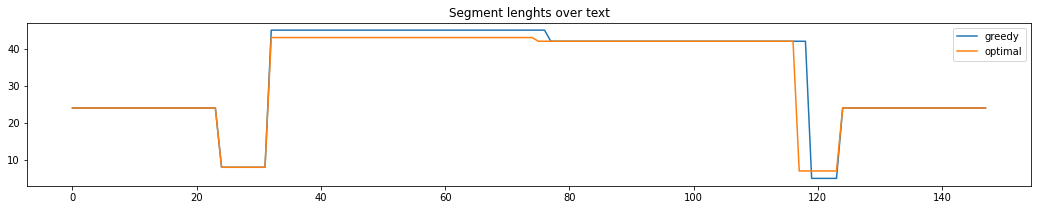

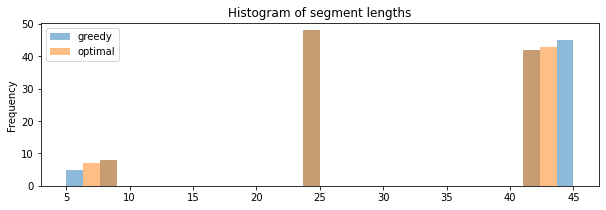

In [ ]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [ ]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Welcome to the huberman Lab podcast, where we discuss science and science based tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system regulates our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanisms. ", 'Isms, one of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding. ', "Even if you're not much of a sweet tooth. ", 'I confess. ', "I'm not most people enjoy sweet tastes more than bitter tastes and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally. ', 'Sweet taste al

In [ ]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [ ]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 150)


In [ ]:
for headline in headlines:
  print(headline)
  

{'generated_text': 'The Ins and Outs of Sugar'}
{'generated_text': 'The Brain-Body Contract Live Event - Seattle on May 17th and Portland on May'}
{'generated_text': 'The Inside Tracker Podcast - Let It Greens'}
{'generated_text': 'The Effects of Sugar on the Nervous System'}
{'generated_text': 'Glucose Blood - What Is It?'}
{'generated_text': 'Insulin Response to Clamp Blood Glucose Levels'}


In [ ]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Ins and Outs of Sugar']
['The Ins and Outs of Sugar']
<class 'str'>
['The Brain', '-', 'Body Contract Live Event', '-', 'Seattle on May 17th and Portland on May']
['The Brain', '-', 'Body Contract Live Event', ' ', 'Seattle on May 17th and Portland on May']
<class 'str'>
['The Inside Tracker Podcast', '-', 'Let It Greens']
['The Inside Tracker Podcast', '-', 'Let It Greens']
<class 'str'>
['The Effects of Sugar on the Nervous System']
['The Effects of Sugar on the Nervous System']
<class 'str'>
['Glucose Blood', '-', 'What Is It?']
['Glucose Blood', '-', 'What Is It?']
<class 'str'>
['Insulin Response to Clamp Blood Glucose Levels']
['Insulin Response to Clamp Blood Glucose Levels']
<class 'str'>


In [ ]:
for headline_string in headlines_string:
  print(headline_string)

 The Ins and Outs of Sugar
 The Brain - Body Contract Live Event Seattle on May 17th and Portland on May
 The Inside Tracker Podcast - Let It Greens
 The Effects of Sugar on the Nervous System
 Glucose Blood - What Is It?
 Insulin Response to Clamp Blood Glucose Levels
